In [15]:
# Submission by Deepa Gupta to technical challenge for job application at RNI, WVU

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

     Unnamed: 0       Date  HR_Average   HRV  Durations
0             0  3/17/2020       65.58  51.0   5.550000
1             1  3/18/2020       65.35  51.0   8.950000
2             2  3/19/2020       69.80  43.0   7.033333
3             3  3/20/2020       69.76  43.0   7.033333
4             4  3/21/2020       70.48  53.0   4.950000
..          ...        ...         ...   ...        ...
422         422  5/13/2021       83.62  19.0   5.483333
423         423  5/14/2021         NaN   NaN        NaN
424         424  5/15/2021       68.53  65.0   6.183333
425         425  5/16/2021       80.77  27.0   5.150000
426         426  5/17/2021       62.92  58.0   5.833333

[427 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  427 non-null    int64  
 1   Date        427 non-null    object 
 2   HR_Average  389 non-null    flo

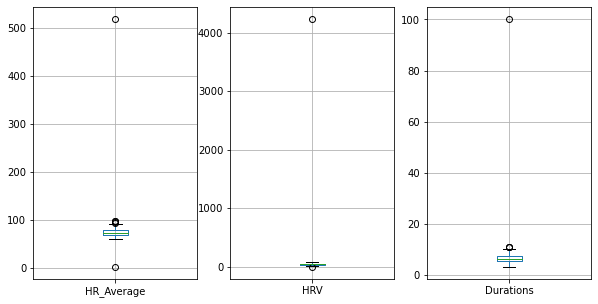

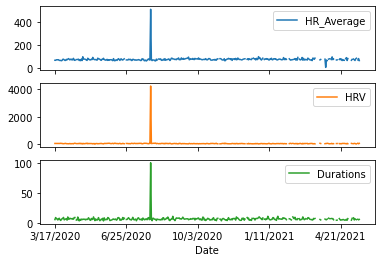

In [16]:
# Task 1: Reading the data 

## 1.1. Read the CSV file into a Pandas DataFrame
# Data imported using Pandas DataFrame as shown below
df = pd.read_csv('Data Scientist - 18624 Technical Challenge Data.csv')

print(df) 


## 1.2. What is some basic information about the data? Does it match the schema and shape provided above?
# Response: (a) Data has serial number, date, heart rate (average), heart rate variability and duration. 
#           (b)Yes, it matches. 

print(df.info())
print('Data read successfully from the CSV and yes, it matches the given description')

print('(Total data entries are ', df.shape[0],')')

print('\n Raw Data Visualizations:')
plot_cols = ['HR_Average', 'HRV', 'Durations']
fig, ax = plt.subplots(1, len(plot_cols), figsize=(10, 5))
for i in range(len(plot_cols)):
 df.boxplot(plot_cols[i], ax=ax[i]);

plot_features = df[plot_cols]
plot_features.index = df['Date']
_ = plot_features.plot(subplots=True)

In [17]:
## 1.3. Will you make any changes to the data types? 
# Response: Not required. I am making no changes to the data types. 
df.rename(columns = {'Unnamed: 0':'Serial_No'}, inplace = True)
print(df.info())
print(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 427 entries, 0 to 426
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Serial_No   427 non-null    int64  
 1   Date        427 non-null    object 
 2   HR_Average  389 non-null    float64
 3   HRV         389 non-null    float64
 4   Durations   389 non-null    float64
dtypes: float64(3), int64(1), object(1)
memory usage: 16.8+ KB
None
     Serial_No       Date  HR_Average   HRV  Durations
0            0  3/17/2020       65.58  51.0   5.550000
1            1  3/18/2020       65.35  51.0   8.950000
2            2  3/19/2020       69.80  43.0   7.033333
3            3  3/20/2020       69.76  43.0   7.033333
4            4  3/21/2020       70.48  53.0   4.950000
..         ...        ...         ...   ...        ...
422        422  5/13/2021       83.62  19.0   5.483333
423        423  5/14/2021         NaN   NaN        NaN
424        424  5/15/2021       68.53  65.0   

In [18]:
# Task 2: Understanding the data

# Often, cleaning and exploration go hand-in-hand. As you explore deeper, you may discover that more needs to be cleaned, 
# imputed, or processed, so these are in no particular order. Use your data science wisdom to inform what and how to clean!

## Exploration
# ■ This is purely open-ended and you can explore as much or as little data as you wish. Please be intentional with your 
# exploration. We encourage you to examine various statistics, build relevant visualizations, and discuss your insights.
# ■ How is your exploration helping to inform your future decisions about a model choice?

## Cleaning & Processing
# ■ Does the dataset need any cleaning? If so, what procedures did you use?
# ■ How do you plan to process and split your data in preparation for modeling?

# Please see responses below along with relevant code execution:

In [19]:
# Before modeling, I cleaned my data by removing the rows without any data first so that it doesn't lead to any wrong results. 

print('Correcting date, and removing duplicates:')

# a - I executed code so that any date in possibly wrong format or null value were corrected or dropped
df['Date'] = pd.to_datetime(df['Date']) 
df.dropna(subset=['Date'], inplace = True)

# b - I checked for and accordingly dropped any duplicates
print(df.duplicated()) # returned false, no duplicates found
# df.drop_duplicates(inplace = True) # no duplicates were found. Hence, commented to avoid extra computer load (O(N)).

old_df = df # saving a copy

Correcting date, and removing duplicates:
0      False
1      False
2      False
3      False
4      False
       ...  
422    False
423    False
424    False
425    False
426    False
Length: 427, dtype: bool


In [20]:
# c - Thresholding based interpolation on normal day duration for sleep, 60-100 bpm for average heart rate, and 20-200ms for HRV

SLEEP_MIN = 0 #safely taking it as minimum hours in a day = 0
SLEEP_MAX = 24 #safely taking it as maximum hours in a day = 24 
HR_AVG_MIN = 50  #safer side minimum, taking slightly lower than 60
HR_AVG_MAX = 300 #safer side maximum, in case the person is exercising (220-age)
HRV_MIN = 10  #safer side minimum, taking slightly lower than 20
HRV_MAX = 250 #safer side maximum, taking slightly higher than 200

# If any value was beyond these threshold values then they were replaced by the average of the preceding two data values
# Logistics for taking average of preceding values: generally one ensures that the setup is ok and starting data is correct 

pd.options.mode.chained_assignment = None  # default='warn'
for i in df.index:
    if i > 1:
        if df['HR_Average'][i] < HR_AVG_MIN or df['HR_Average'][i] > HR_AVG_MAX:
            df['HR_Average'][i] = (df['HR_Average'][i-2] + df['HR_Average'][i-1])/2
        if df['HRV'][i] < HRV_MIN or df['HRV'][i] > HRV_MAX:
            df['HRV'][i] = (df['HRV'][i-2] + df['HRV'][i-1])/2
        if df['Durations'][i] < SLEEP_MIN or df['Durations'][i] > SLEEP_MAX:
            df['Durations'][i] = (df['Durations'][i-2] + df['Durations'][i-1])/2
            


In [21]:
# d - Interpolated missing data (NaNs) by using linear regression 
# (source: https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html)

plot_cols = ['HR_Average', 'HRV', 'Durations']

old_thresholded_df = df # saving a copy of the dataset just in case
df = df[plot_cols] # eliminated dates' column
lr = LinearRegression()
imp = IterativeImputer(estimator=lr, max_iter=30, tol=1e-10, imputation_order='roman')
df = imp.fit_transform(df)

In [22]:
df = pd.DataFrame(df,columns=plot_cols)

(Total data entries are  427 )

Post Cleaning Data Visualizations:


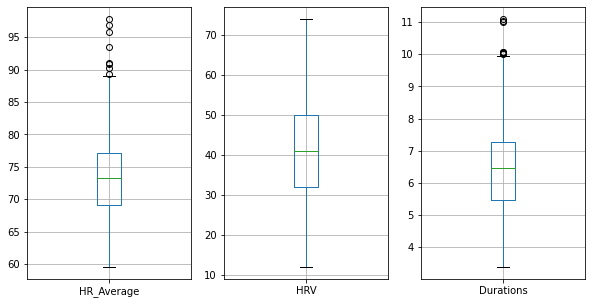

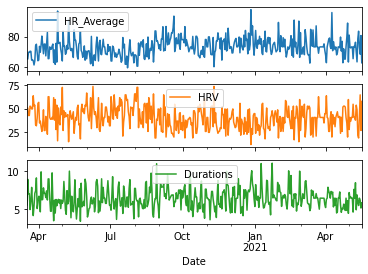

In [23]:
print('(Total data entries are ', df.shape[0],')')

print('\nPost Cleaning Data Visualizations:')
fig, ax = plt.subplots(1, len(plot_cols), figsize=(10, 5))
for i in range(len(plot_cols)):
 df.boxplot(plot_cols[i], ax=ax[i]);

plot_features = df[plot_cols]
plot_features.index = old_thresholded_df['Date']
_ = plot_features.plot(subplots=True)

In [24]:
#Task 3: Modeling the data to achieve the goal

#○ What model did you choose? Why?
# Response: 
# I chose multiple parallel multi step output RNN model. As per my readings, ANNs are more accurate.
# Listing selective sources:
# Tao, K., Li, J., Li, J., Shan, W., Yan, H., & Lu, Y. (2021). 
# Estimation of heart rate using regression models and artificial neural network in middle-aged adults. 
# Frontiers in Physiology, 1675
# https://www.tensorflow.org/tutorials/structured_data/time_series#multi-step_models
# Also, LSTM are more powerful as they account for more context from past data readings

#○ What metric(s) did you choose to optimize? Why?
# Response: 
# I checked for lack of change in correlation values before and after prediction as a mteric to account for accuracy in prediction. 
# This is because if accurately predicted, correlation would be more or less the same. Correlation increased from 0.214458 to
# 0.214415, which is less than 1e-4 and hence, a tolerable change. Therefore, seems to be a consistent prediction 

#○ Does your model generalize well? How did you validate & verify its performance?
# Response: 
# It generalizes well as it took training data as the whole time series with five time steps from each of the three time series 
# as input to the validate and verify the next three time steps of each of the three time series as output. Finally, I used the 
# last five time steps from each of the three time series as input to the model and predict the next three time steps of each 
# of the three time series as output.

#○ Can you think of a simpler model to compare yours against as a baseline?
# Response: 
# Regression

#○ If you had more time, how might you improve your model? What other strategies might you try?
# Response: 
# By checking for accuracy yielded against other models. 

#○ What other data do you wish you had that might be helpful for this task?
# Response: 
# Response: Additional data records of age, BMI, heart disease conditions, exercise time and level for each entry would be useful


In [25]:
df.corr()

HR_Average       HRV  Durations
HR_Average    1.000000 -0.880156   0.214458
HRV          -0.880156  1.000000  -0.090117
Durations     0.214458 -0.090117   1.000000

In [26]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence (eliminated HRV to aoid redundancy as it has high anticorrelation of -0.88)
in_seq1 = array(df['Durations'])
out_seq = array(df['HR_Average'])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, out_seq)) 
# choose a number of time steps
n_steps_in, n_steps_out = 5, 3
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=300, verbose=0)
# demonstrate prediction
x_input = array(dataset[(len(dataset)-n_steps_in):len(dataset), :])
x_input = x_input.reshape(1, n_steps_in, n_features)
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[ 6.5031724 72.74289  ]
  [ 6.559114  72.78969  ]
  [ 6.5258355 72.645    ]]]


In [27]:
new_X = pd.DataFrame(dataset.reshape((427,2)))
new_yhat = pd.DataFrame(yhat.reshape((3,2)))
new_X = new_X.append(new_yhat)
new_X.corr()

/var/folders/t5/sj1q552s6sz4b7ft46q4tjjw0000gn/T/ipykernel_13820/185701644.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_X = new_X.append(new_yhat)


0         1
0  1.000000  0.214415
1  0.214415  1.000000

In [28]:
yhat_df = pd.DataFrame(yhat.reshape((3,2)),columns=['predicted_Durations', 'HR_Average_forecast'])
Dates = ['5/18/2021','5/19/2021','5/20/2021']
yhat_df.insert(0,'Date',Dates)
print(yhat_df)
forecast = yhat_df[['Date', 'HR_Average_forecast']]
forecast.to_csv('predictions_DG.csv', index = False)
print('Predicted values are saved in the output predictions_DG.csv file')
print('File content with selective columns as was requested is:')
print(forecast)

        Date  predicted_Durations  HR_Average_forecast
0  5/18/2021             6.503172            72.742889
1  5/19/2021             6.559114            72.789688
2  5/20/2021             6.525836            72.644997
Predicted values are saved in the output predictions_DG.csv file
File content with selective columns as was requested is:
        Date  HR_Average_forecast
0  5/18/2021            72.742889
1  5/19/2021            72.789688
2  5/20/2021            72.644997


In [ ]:
# Thank you for the consideration <|>